In [1]:
import umap
import numpy as np
import pandas as pd
import requests
import os
import datashader as ds
import datashader.utils as utils
import datashader.transfer_functions as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set(context="paper", style="white")

if not os.path.isfile("fashion-mnist.csv"):
    csv_data = requests.get("https://www.openml.org/data/get_csv/18238735/phpnBqZGZ")
    with open("fashion-mnist.csv", "w") as f:
        f.write(csv_data.text)
source_df = pd.read_csv("fashion-mnist.csv")

In [3]:
data = source_df.iloc[:, :784].values.astype(np.float32)
target = source_df["class"].values

pal = [
    "#9e0142",
    "#d8434e",
    "#f67a49",
    "#fdbf6f",
    "#feeda1",
    "#f1f9a9",
    "#bfe5a0",
    "#74c7a5",
    "#378ebb",
    "#5e4fa2",
]
color_key = {str(d): c for d, c in enumerate(pal)}

In [4]:
reducer = umap.UMAP(random_state=42, verbose=True)
embedding = reducer.fit_transform(data)

UMAP(random_state=42, verbose=True)
Wed Dec 22 12:47:52 2021 Construct fuzzy simplicial set
Wed Dec 22 12:47:52 2021 Finding Nearest Neighbors
Wed Dec 22 12:47:52 2021 Building RP forest with 18 trees
Wed Dec 22 12:47:53 2021 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Wed Dec 22 12:47:59 2021 Finished Nearest Neighbor Search
Wed Dec 22 12:48:00 2021 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Wed Dec 22 12:48:27 2021 Finished embedding


In [5]:
%matplotlib widget

Text(0.5, 1.0, 'Fashion MNIST data embedded\ninto two dimensions by UMAP\nvisualised with Datashader')

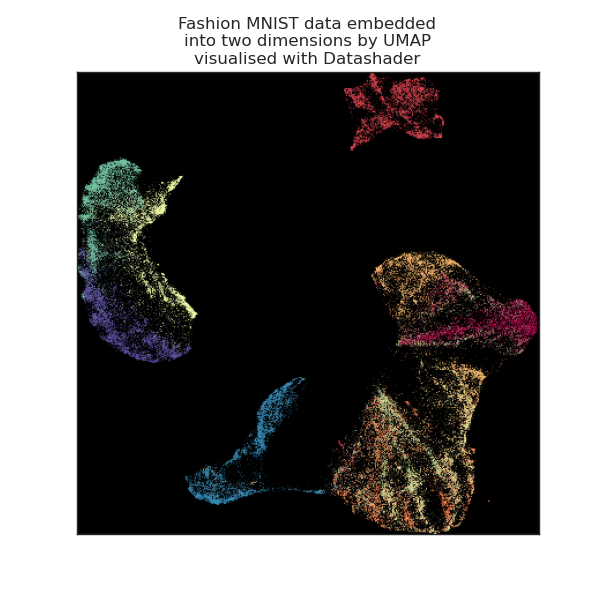

In [6]:

df = pd.DataFrame(embedding, columns=("x", "y"))
df["class"] = pd.Series([str(x) for x in target], dtype="category")

cvs = ds.Canvas(plot_width=400, plot_height=400)
agg = cvs.points(df, "x", "y", ds.count_cat("class"))
img = tf.shade(agg, color_key=color_key, how="eq_hist")

utils.export_image(img, filename="fashion-mnist", background="black")

image = plt.imread("fashion-mnist.png")
fig, ax = plt.subplots(figsize=(6, 6))
plt.imshow(image)
plt.setp(ax, xticks=[], yticks=[])
plt.title(
    "Fashion MNIST data embedded\n"
    "into two dimensions by UMAP\n"
    "visualised with Datashader",
    fontsize=12,
)

---

In [13]:
#!/usr/bin/env python
# coding: utf-8
import os
from itertools import combinations
import multiprocessing as mp

import networkx as nx
import cell_lattices as cx

import numpy as np
import pandas as pd
import scipy.special as sp
from scipy.spatial import distance as dist
from tqdm import tqdm

import umap

import colorcet as cc
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Options for saving output(s)
save     = True
save_dir = os.path.realpath("./plots")
fmt      = "png"
dpi      = 300

# Get coordinates and adjacency for a periodic square lattice
rows = cols = 5
X = cx.hex_grid(rows, cols)
A = cx.make_adjacency_periodic(rows, cols)

# Make master cell graph
G = nx.from_numpy_matrix(A)

# Get total number of cells and a subset
n = A.shape[0]
n_sub = n // 2

# Get total number of permutations this tissue can undergo
ncomb = int(sp.comb(n, n_sub))

In [3]:
# Make generator of all cell type combinations
gen = combinations(np.arange(n), n_sub)

# Make Boolean array of all combinations
combs = np.zeros((ncomb, n), dtype=bool)
for i in tqdm(range(ncomb)):
    idx = next(gen)
    combs[i, idx] = True

100%|█████████████████████████████████████████| 5200300/5200300 [00:11<00:00, 458019.25it/s]


In [ ]:
def n_connected_components(idx):
    """Compute number of connected components given cell indices"""
    return nx.number_connected_components(G.subgraph(idx))

# Parallelize calculation of tissue topology (# coneccted components)
if __name__ == '__main__':
    
    # Get cluster
    n_workers = mp.cpu_count()
    pool = mp.Pool(n_workers)
    
    # Compute results as array
    iterator = combinations(np.arange(n), n_sub)
    result_list = pool.map(n_connected_components, iterator)
    ncc = np.asarray(result_list)

In [12]:
combs_str = ["".join([str(int(c)) for c in comb]) for comb in combs]

In [14]:
combs_df = pd.DataFrame(dict(combination=combs_str, n_connected_components=ncc))

In [16]:
df_fname = os.path.realpath("cell_graph_combinations.csv")
combs_df.to_csv(df_fname, index=False)

In [17]:
combs_df = pd.read_csv(df_fname)

In [ ]:
## Perform UMAP
# Select data
# data_slice = slice(None, None, None)
data_slice = slice(0, 3000000, 30000)
data       = combs[data_slice]
clusters   = ncc[data_slice]
colors     = [sns.color_palette()[i] for i in clusters]

# Perform UMAP with progress
reducer   = umap.UMAP(metric="hamming", verbose=True)
embedding = reducer.fit_transform(combs)

/home/pbhamidi/git/cell-lattices/env/lib/python3.9/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


UMAP(metric='hamming', verbose=True)
Wed Dec 22 13:10:19 2021 Construct fuzzy simplicial set
Wed Dec 22 13:10:19 2021 Finding Nearest Neighbors
Wed Dec 22 13:10:19 2021 Building RP forest with 64 trees
Wed Dec 22 13:11:12 2021 NN descent for 22 iterations
	 1  /  22
	 2  /  22
	Stopping threshold met -- exiting after 2 iterations
Wed Dec 22 13:12:16 2021 Finished Nearest Neighbor Search
Wed Dec 22 13:12:52 2021 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

In [ ]:
# Plot
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=colors)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of tissue topologies ($5 \times 5$)', fontsize=18)
    
if save:
    fname = "topology_UMAP_5x5_"
    fpath = os.path.join(save_dir, fname + "." + fmt)
    plt.savefig(fpath, dpi=dpi)
else:
    plt.show()